<a href="https://colab.research.google.com/github/Barabaika/rna-cite-compit2022/blob/scMVP/cite_3_inps_cnn_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install colorama
# !pip install tensorflow-addons
# !pip install keras-tuner
# import os, gc, pickle, datetime, scipy.sparse
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# from colorama import Fore, Back, Style

# from sklearn.model_selection import KFold,GroupKFold, train_test_split
# from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
# # from sklearn.decomposition import TruncatedSVD

# import tensorflow as tf
# import tensorflow.keras.backend as K
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
# from tensorflow.keras.layers import Dense, Input, Concatenate, LayerNormalization, Layer, MultiHeadAttention, Reshape, Attention, Conv1D, \
#     MaxPool1D, Dropout, BatchNormalization, Flatten, AveragePooling1D, Multiply

# from tensorflow_addons.layers import WeightNormalization, AdaptiveAveragePooling1D

# from tensorflow.keras.utils import plot_model
# import keras_tuner
# from sklearn.model_selection import StratifiedKFold
# # from sklearn.preprocessing import minmax_scale

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 42.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 32.4 MB/s 
     |████████████████████████████████| 1.6 MB 75.9 MB/s 


In [2]:
# from google.colab import drive
# drive.mount("/content/gdrive", force_remount=True)

!mkdir /root/.kaggle
!cp /content/gdrive/MyDrive/kaggle/kaggle.json /root/.kaggle


!mkdir data
!unzip /content/gdrive/MyDrive/kaggle/metadata.csv.zip -d data
!unzip /content/gdrive/MyDrive/kaggle/train_cite_targets.h5.zip -d data

!kaggle datasets download -d geraseva/target-genes-denoised
!kaggle datasets download -d geraseva/cite-inputs-dca-pca
!kaggle datasets download -d grac2h5/top-100-closest-to-target-genes-with-features

!unzip -q target-genes-denoised.zip -d data
!unzip -q cite-inputs-dca-pca.zip -d data
!unzip -q top-100-closest-to-target-genes-with-features -d data

Mounted at /content/gdrive
Archive:  /content/gdrive/MyDrive/kaggle/metadata.csv.zip
  inflating: data/metadata.csv       
Archive:  /content/gdrive/MyDrive/kaggle/train_cite_targets.h5.zip
  inflating: data/train_cite_targets.h5  
 97% 625M/645M [00:05<00:00, 135MB/s]
100% 645M/645M [00:05<00:00, 131MB/s]
 83% 88.0M/106M [00:00<00:00, 112MB/s]
100% 106M/106M [00:00<00:00, 129MB/s] 
 99% 3.38G/3.40G [00:26<00:00, 160MB/s]
100% 3.40G/3.40G [00:26<00:00, 139MB/s]


In [3]:
DATA_DIR = "/content/data"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")


# Chnage to denoized data with deafult magic params (knn_5_t3) 
# FP_CITE_TRAIN_INPUTS_DENOISED = '../input/citeseq-denoised/train_cite_inputs_denoised.h5'
# FP_CITE_TEST_INPUTS_DENOISED = '../input/citeseq-denoised/test_cite_inputs_denoised.h5'
# FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
# FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

# importtant cols for cite seq input we will take from this table  
# FP_IMPORTANT_GENES = '../input/important-cols-citeseq/TotalSeq_B_Universal_Cocktail_v1_140_Antibodies_399904_Barcodes.csv'

# FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")



# FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
# FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
# FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

# FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
# FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

TUNE = False
SUBMIT = True

In [4]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def negative_correlation_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, y_true.shape[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(y_true.shape[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

def std(x):
    return (x - np.mean(x)) / np.std(x)

In [5]:
X_imp_genes = pd.read_csv('/content/data/citeseq_target_genes_denoised_dca.csv')
X_imp_genes = X_imp_genes.set_index('cell_id')

X_train_imp_genes = X_imp_genes.iloc[:70988, :].values
X_test_imp_genes = X_imp_genes.iloc[70988:, :].values

assert X_test_imp_genes.shape[0] == 48663

meta = pd.read_csv(FP_CELL_METADATA, index_col='cell_id')
meta = meta.reindex(X_imp_genes.iloc[:70988, :].index)
print(meta.shape)

del X_imp_genes
gc.collect()

(70988, 4)


22

In [6]:
X_dim_red = pd.read_csv('/content/data/cite_inputs_dca_denoised_PCA200.csv')
X_dim_red = X_dim_red.drop('Unnamed: 0', axis = 1)

X_train_dim_red = X_dim_red.iloc[:70988, :].values
X_test_dim_red = X_dim_red.iloc[70988:, :].values

del X_dim_red
gc.collect()

22

In [7]:
#loading data from Antom (top 100 closest to tagret genes with features)
top100_folder = 'mean_by_target_denoised/'
list_f = [
    os.path.join(DATA_DIR, top100_folder, 'anti-human_CD63_semantic_similarity.csv'),
    os.path.join(DATA_DIR, top100_folder, 'anti-human_CD49b_semantic_similarity.csv'),
    os.path.join(DATA_DIR, top100_folder, 'anti-human_CD62L_semantic_similarity.csv'),
    os.path.join(DATA_DIR, top100_folder, 'anti-human_HLA-DR_semantic_similarity.csv')
         ]
list_d = []
for f in list_f:
    d = pd.read_csv(f, index_col = 0)
    list_d.append(d)


X_all_conected = pd.concat(list_d, axis = 1)
# constant_in_conected = [i.split('_')[1] for i in constant_cols if i.split('_')[1] in X_all_conected.columns]
# X_all_conected = X_all_conected.drop(constant_in_conected, axis = 1)
X_all_conected.shape

X_train_connect = X_all_conected.iloc[:70988, :].values
X_test_connect = X_all_conected.iloc[70988:, :].values

print(X_train_connect.shape)
print(X_test_connect.shape)

(70988, 220)
(48663, 220)


In [8]:
# std scaling:

X_train_dim_red = std(X_train_dim_red) # minmax_scale
X_test_dim_red = std(X_test_dim_red)

X_train_connect = std(X_train_connect)
X_test_connect = std(X_test_connect)

X_train_imp_genes = std(X_train_imp_genes)
X_test_imp_genes = std(X_test_imp_genes)

In [9]:
# Read Y
Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
y_columns = list(Y.columns)
Y = Y.values

# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
Y = std(Y)

print(f"Y shape: {str(Y.shape):14} {Y.size*4/1024/1024/1024:2.3f} GByte")

Y shape: (70988, 140)   0.037 GByte


In [10]:
scol = 'donor&day&CT'
meta[scol] =meta['donor'].apply(lambda x:str(x)+'_') + meta['day'].apply(lambda x:str(x)+'_') + meta['cell_type']
meta

y = meta[scol] 
skf = StratifiedKFold(n_splits=10,  shuffle=True, random_state=40)
skf.get_n_splits(meta, meta[scol] )
for train_index, test_index in skf.split(meta, meta[scol]):
    print("TRAIN:", len(train_index), "TEST:", len(test_index) ); break

meta['HoldOut'] = 0 
meta.loc[meta.index[test_index],'HoldOut']  = 1


list_folds_indices_by_days_and_donors_with2holdouts = []
c = 0
for day2exclude in [2,3,4]:
    for donor2exclude in [32606,  31800]: # We will need to predict always MALE (not female) - like on LB. (# donor 13176 - female)
        train_index = np.where( (meta['day']  != day2exclude) & ( meta['donor']  != donor2exclude  ) )  [0]
        mask_holdout = (meta['HoldOut']==1)
        test_index1_like_private_lb = np.where( (meta['day']  == day2exclude) & (~mask_holdout) ) [0]
        test_index1_like_private_lb_holdout = np.where( (meta['day']  == day2exclude) & (mask_holdout) ) [0]
        test_index2_like_public_lb = np.where( (meta['day']  != day2exclude) &  (meta['donor']  == donor2exclude ) & (~mask_holdout) ) [0]
        test_index2_like_public_lb_holdout = np.where( (meta['day']  != day2exclude) &  (meta['donor']  == donor2exclude ) & mask_holdout ) [0]
        
        list_folds_indices_by_days_and_donors_with2holdouts.append( 
            (train_index,  
             test_index1_like_private_lb , 
             test_index2_like_public_lb, 
             test_index1_like_private_lb_holdout, 
             test_index2_like_public_lb_holdout ) 
        )
    
        str_fold_inf = 'Fold ' +str(c) + ': Train: excludes Day '+str(day2exclude) + ' and Donor ' + str( donor2exclude )
        print(str_fold_inf, 'Sizes: train:',len(train_index), 'Test Like Priv'  ,len(test_index1_like_private_lb), 
              'Test Like Publ',   len(test_index2_like_public_lb),  
              'Test Like Priv HoldOut',   len(test_index1_like_private_lb_holdout),  
              'Test Like Publ HoldOut',   len(test_index2_like_public_lb_holdout),  
              
             ); c+=1
    
print(len(list_folds_indices_by_days_and_donors_with2holdouts))

TRAIN: 63889 TEST: 7099
Fold 0: Train: excludes Day 2 and Donor 32606 Sizes: train: 32536 Test Like Priv 19748 Test Like Publ 14859 Test Like Priv HoldOut 2194 Test Like Publ HoldOut 1651
Fold 1: Train: excludes Day 2 and Donor 31800 Sizes: train: 32638 Test Like Priv 19748 Test Like Publ 14767 Test Like Priv HoldOut 2194 Test Like Publ HoldOut 1641
Fold 2: Train: excludes Day 3 and Donor 32606 Sizes: train: 33100 Test Like Priv 18811 Test Like Publ 15288 Test Like Priv HoldOut 2090 Test Like Publ HoldOut 1699
Fold 3: Train: excludes Day 3 and Donor 31800 Sizes: train: 31543 Test Like Priv 18811 Test Like Publ 16690 Test Like Priv HoldOut 2090 Test Like Publ HoldOut 1854
Fold 4: Train: excludes Day 4 and Donor 32606 Sizes: train: 28368 Test Like Priv 25330 Test Like Publ 13027 Test Like Priv HoldOut 2815 Test Like Publ HoldOut 1448
Fold 5: Train: excludes Day 4 and Donor 31800 Sizes: train: 28189 Test Like Priv 25330 Test Like Publ 13189 Test Like Priv HoldOut 2815 Test Like Publ HoldO

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


In [11]:
def get_fold(fold_number, X, Y, fold_map):
    '''
    fold_map
    X: sparce matrix
    '''
    
    X_train = X[fold_map[int(fold_number)][0]]
    
    X_test_priv = X[fold_map[int(fold_number)][1]]
    X_test_publ = X[fold_map[int(fold_number)][2]]
    
    X_test_priv_holdout = X[fold_map[int(fold_number)][3]]
    X_test_publ_holdout = X[fold_map[int(fold_number)][4]]
    
    Y_train = Y[fold_map[int(fold_number)][0]]
    
    Y_test_priv = Y[fold_map[int(fold_number)][1]]
    Y_test_publ = Y[fold_map[int(fold_number)][2]]
    
    Y_test_priv_holdout = Y[fold_map[int(fold_number)][3]]
    Y_test_publ_holdout = Y[fold_map[int(fold_number)][4]]
    
    return X_train, X_test_priv, X_test_publ, X_test_priv_holdout, X_test_publ_holdout, Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout

In [12]:
#########attention part 
# connect_genes = Reshape((connect_genes.shape[1], 1))(connect_genes)
#     dim_reduced_genes = Reshape((dim_reduced_genes.shape[1], 1))(dim_reduced_genes)
#     important_genes = Reshape((important_genes.shape[1], 1))(important_genes)
#     # cross attention with connect genes
# #     x = MultiHeadAttention(num_heads=hp.Choice(f'n_heads', [2,4,6,8]), key_dim = x.shape[1])(x, connect_genes, dim_reduced_genes)
#     x = Attention(use_scale = True)([x, connect_genes, dim_reduced_genes])
#     x = LayerNormalization(axis=1)(x)
# #     # self attention
#     x = Attention(use_scale = True)([x, x, x])
# #     x = MultiHeadAttention(num_heads=hp.Choice(f'n_heads', [2,4,6,8]), key_dim = x.shape[1])(x, x, x)
#     x = LayerNormalization(axis=1)(x)
# #     # cross attention with imp genes
#     x = Attention(use_scale = True)([x, important_genes, dim_reduced_genes])
# #     x = MultiHeadAttention(num_heads=hp.Choice(f'n_heads', [2,4,6,8]), key_dim = x.shape[1])(x, important_genes, dim_reduced_genes)
#     x = LayerNormalization(axis=1)(x)                                                           
# #     # self attention
# #     x = MultiHeadAttention(num_heads=hp.Choice(f'n_heads', [2,4,6,8]), key_dim = x.shape[1])(x, x, x)
#     x = Attention(use_scale = True)([x, x, x])
#     x = LayerNormalization(axis=1)(x)
    
#     x = Reshape((x.shape[1],))(x)

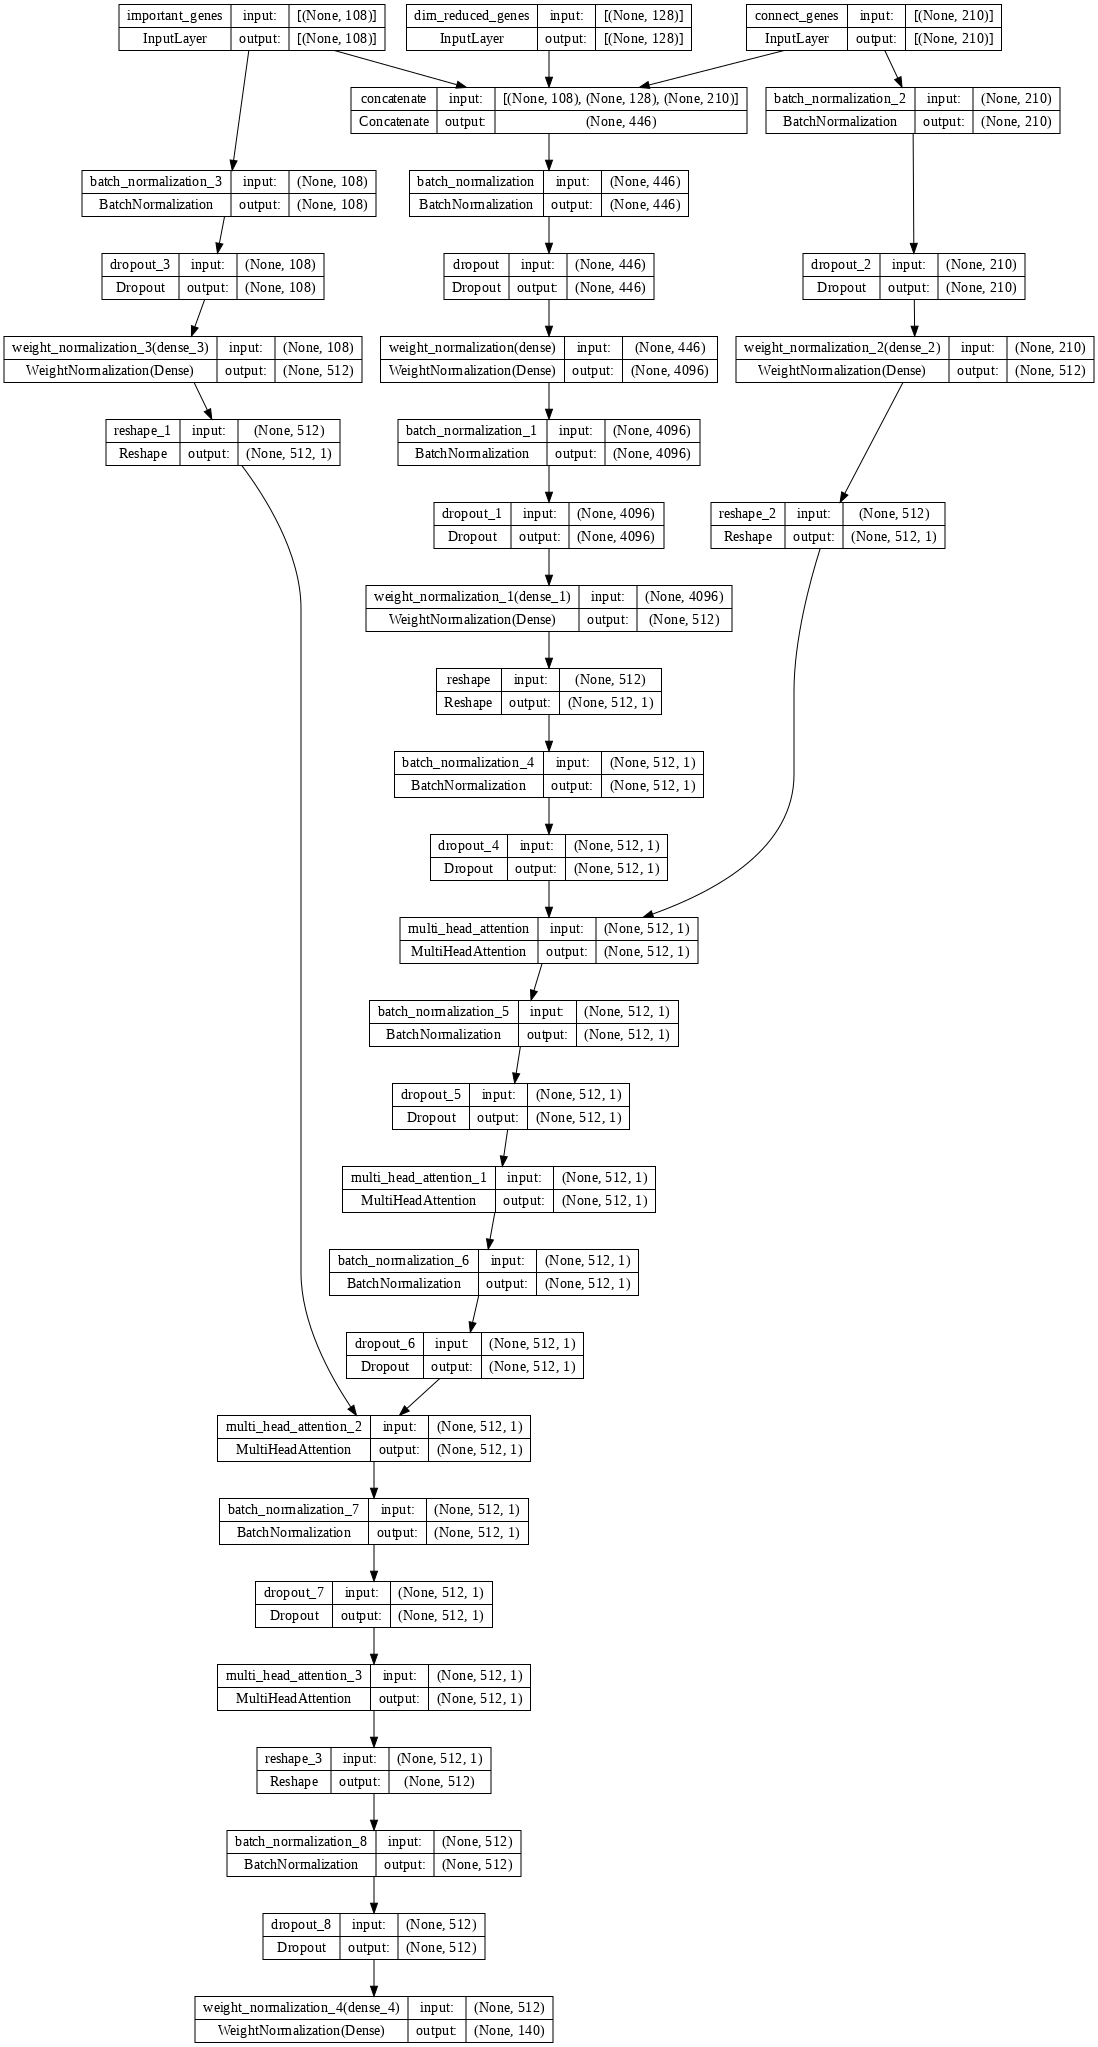

In [13]:
LR_START = 0.01
BATCH_SIZE = 256
def my_model(hp, n_inputs_imp_genes = 108, n_inputs_dim_red = 128, n_inputs_connect = 210):    
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation_first = hp.Choice('activation_first', ["swish",'celu', 'gelu'])
    activation = hp.Choice('activation_other', ["swish",'celu', 'gelu'])

#     reg1 = hp.Float("reg1", min_value=1e-8, max_value=1e-4, sampling="log")
#     reg2 = hp.Float("reg2", min_value=1e-10, max_value=1e-5, sampling="log")
    
    important_genes_input = Input(shape=(n_inputs_imp_genes, ), name="important_genes")
    dim_reduced_genes_input = Input(shape=(n_inputs_dim_red, ), name = "dim_reduced_genes")
    connect_genes_input = Input(shape=(n_inputs_connect, ), name = "connect_genes")
    
    x = Concatenate()([important_genes_input, dim_reduced_genes_input, connect_genes_input])
    
    hidden_size = hp.Choice('hidden_size', [2048, 4096], default = 4096)
    num_targets = Y.shape[1]
    cha_1 = hp.Choice('flatten_to_channels', [128, 256, 512], default = 256)
    cha_2 = hp.Choice('channels2', [128, 256, 512], default = 512)
    cha_3 = hp.Choice('channels3', [128, 256, 512], default = 512)
    
    cha_1_reshape = int(hidden_size/cha_1)
    cha_po_1 = int(hidden_size/cha_1/2)
    cha_po_2 = int(hidden_size/cha_1/2/2) * cha_3
    
    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.1)(x)
    x = WeightNormalization(
        Dense(hidden_size, activation = activation_first),
        data_init=False
    )(x)
    
    # x = Reshape((cha_1, cha_1_reshape))(x)
    
    # x = BatchNormalization(axis=1)(x)
    # x = Dropout(0.1)(x)
    # x = WeightNormalization(
    #      Conv1D(cha_2,kernel_size = 5, strides = 1, padding='same', use_bias=False),
    #     data_init=False
    # )(x)
    
    # x = AdaptiveAveragePooling1D(output_size = cha_po_1)(x)
    
    # x = BatchNormalization(axis=1)(x)
    # x = Dropout(0.1)(x)
    # x = WeightNormalization(
    #      Conv1D(cha_2,kernel_size = 3, strides = 1, padding='same', use_bias=False),
    #     data_init=False
    # )(x)
    
    # x_s = x
    
    # x = BatchNormalization(axis=1)(x)
    # x = Dropout(0.3)(x)
    # x = WeightNormalization(
    #      Conv1D(cha_2,kernel_size = 3, strides = 1, padding='same', use_bias=False),
    #     data_init=False
    # )(x)
    
    # x = BatchNormalization(axis=1)(x)
    # x = Dropout(0.2)(x)
    # x = WeightNormalization(
    #      Conv1D(cha_3,kernel_size = 5, strides = 1, padding='same',use_bias=False),
    #     data_init=False
    # )(x)
    
    # x = Multiply()([x, x_s])
    # x = MaxPool1D(pool_size=4, strides=2, padding='same')(x)
    
    # x = Flatten()(x)
    
    # x = BatchNormalization(axis=1)(x)
    # x = Dropout(0.2)(x)
    # x = WeightNormalization(
    #     Dense(hp.Choice('dense_after_conv', [128, 256, 512], default = 256), 
    #           activation = activation
    #          ),
    #     data_init=False
    # )(x)

    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.1)(x)
    x = WeightNormalization(
        Dense(512, activation = activation_first),
        data_init=False
    )(x)

    # attention addings part 
    connect_genes = BatchNormalization(axis=1)(connect_genes_input)
    connect_genes = Dropout(0.1)(connect_genes)
    connect_genes = WeightNormalization(
        Dense(x.shape[1], activation = activation_first),
        data_init=False
    )(connect_genes)

    important_genes = BatchNormalization(axis=1)(important_genes_input)
    important_genes = Dropout(0.1)(important_genes)
    important_genes = WeightNormalization(
        Dense(x.shape[1], activation = activation_first),
        data_init=False
    )(important_genes)

    x = Reshape((x.shape[1], 1))(x)
    important_genes = Reshape((important_genes.shape[1], 1))(important_genes)
    connect_genes = Reshape((connect_genes.shape[1], 1))(connect_genes)

    # cross attention with connect genes
    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.1)(x)
    x = MultiHeadAttention(num_heads=hp.Choice(f'n_heads1', [2,4,6]), key_dim = x.shape[1])(x, connect_genes, x)
    
    # self attention 
    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.1)(x)
    x = MultiHeadAttention(num_heads=hp.Choice(f'n_heads2', [2,4,6]), key_dim = x.shape[1])(x, x, x)
    
    # cross attention with important genes
    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.1)(x)
    x = MultiHeadAttention(num_heads=hp.Choice(f'n_heads3', [2,4,6]), key_dim = x.shape[1])(x, important_genes, x)
    
    # self attention 
    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.1)(x)
    x = MultiHeadAttention(num_heads=hp.Choice(f'n_heads4', [2,4,6]), key_dim = x.shape[1])(x, x, x)
    x = Reshape((x.shape[1],))(x)

    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.2)(x)
    x = WeightNormalization(
        Dense(num_targets, 
#               activation = activation_first
             ),
        data_init=False
    )(x)
     
    regressor = Model(
        inputs= [important_genes_input, dim_reduced_genes_input, connect_genes_input], 
        outputs = x
    )
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[negative_correlation_loss],
                      loss=negative_correlation_loss
                     )
    
    return regressor
display(plot_model(my_model(keras_tuner.HyperParameters()), show_layer_names=True, show_shapes=True, dpi=72))

In [14]:

best_hp = keras_tuner.HyperParameters()
best_hp.values = {
    'hidden_size': 4096, 
    'flatten_to_channels': 256,
    'channels2':512,
    'channels3':512,
    'activation_first': 'gelu',
    'activation': 'gelu',
    'dense_after_conv':256, 
    'n_heads1': 2,
    'n_heads2': 2,
    'n_heads3': 2,
    'n_heads4': 2,
}

Epoch 1/300
128/128 - 35s - loss: -5.3659e-01 - negative_correlation_loss: -5.3802e-01 - val_loss: -5.0441e-01 - val_negative_correlation_loss: -5.0318e-01 - lr: 0.0100 - 35s/epoch - 275ms/step
Epoch 2/300
128/128 - 25s - loss: -8.2274e-01 - negative_correlation_loss: -8.2294e-01 - val_loss: -7.3866e-01 - val_negative_correlation_loss: -7.3664e-01 - lr: 0.0100 - 25s/epoch - 196ms/step
Epoch 3/300
128/128 - 25s - loss: -8.2596e-01 - negative_correlation_loss: -8.2596e-01 - val_loss: -7.5324e-01 - val_negative_correlation_loss: -7.5109e-01 - lr: 0.0100 - 25s/epoch - 196ms/step
Epoch 4/300
128/128 - 25s - loss: -8.3622e-01 - negative_correlation_loss: -8.3699e-01 - val_loss: -7.6818e-01 - val_negative_correlation_loss: -7.6637e-01 - lr: 0.0100 - 25s/epoch - 196ms/step
Epoch 5/300
128/128 - 25s - loss: -8.4251e-01 - negative_correlation_loss: -8.4267e-01 - val_loss: -7.7629e-01 - val_negative_correlation_loss: -7.7446e-01 - lr: 0.0100 - 25s/epoch - 196ms/step
Epoch 6/300
128/128 - 25s - lo

101/101 [==============================] - 9s 84ms/step
Fold 0: stopped after  22 epochs
   corr TRAIN=  0.87591
104/104 [==============================] - 1s 7ms/step
   corr PUBLIC=  0.87910
105/105 [==============================] - 1s 8ms/step
   corr PRIVATE=  0.86415
Epoch 1/300
128/128 - 31s - loss: -6.1162e-01 - negative_correlation_loss: -6.1231e-01 - val_loss: -7.0340e-01 - val_negative_correlation_loss: -6.9665e-01 - lr: 0.0100 - 31s/epoch - 240ms/step
Epoch 2/300
128/128 - 25s - loss: -7.9614e-01 - negative_correlation_loss: -7.9625e-01 - val_loss: -7.3629e-01 - val_negative_correlation_loss: -7.2957e-01 - lr: 0.0100 - 25s/epoch - 197ms/step
Epoch 3/300
128/128 - 25s - loss: -8.3020e-01 - negative_correlation_loss: -8.3020e-01 - val_loss: -7.4023e-01 - val_negative_correlation_loss: -7.3365e-01 - lr: 0.0100 - 25s/epoch - 197ms/step
Epoch 4/300
128/128 - 25s - loss: -8.3582e-01 - negative_correlation_loss: -8.3575e-01 - val_loss: -7.4962e-01 - val_negative_correlation_loss: 

101/101 [==============================] - 9s 84ms/step
Fold 1: stopped after  43 epochs
   corr TRAIN=  0.90104
103/103 [==============================] - 1s 7ms/step
   corr PUBLIC=  0.87515
105/105 [==============================] - 1s 9ms/step
   corr PRIVATE=  0.88000
Average  corr PUBLIC = 0.87712
Average  corr PRIVATE= 0.87207


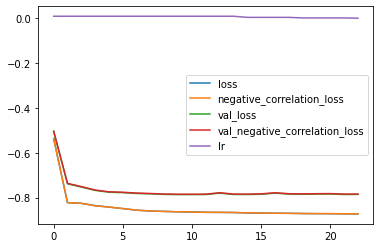

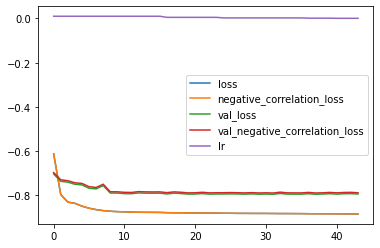

In [15]:
SUBMIT = True

# results
df_fold_score_stat_publ = pd.DataFrame();df_fold_score_stat_publ.index.name = 'dim_red_file'
df_fold_score_stat_priv = pd.DataFrame();df_fold_score_stat_priv.index.name = 'dim_red_file'


# Cross-validation
VERBOSE = 2 # set to 2 for more output
EPOCHS = 300

cv_idxs = list_folds_indices_by_days_and_donors_with2holdouts

np.random.seed(1)
tf.random.set_seed(1)

N_FOLDS = 2

core_list_train = []
score_list_priv = []
score_list_publ = []
va_pred_publ = []
va_pred_priv = []

X_file = '128tSVD+108important_raw_genes+210_connected_genes'


for fold in range(2): # N_FOLDS

    start_time = datetime.datetime.now()
    model = None
    gc.collect()

    X_tr_imp_genes, _, _, X_test_priv_imp_genes, X_test_publ_imp_genes, \
    Y_train, _, _, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(fold, X_train_imp_genes, Y, cv_idxs)
    
    X_tr_dim_red, _, _, X_test_priv_dim_red, X_test_publ_dim_red, \
    Y_train, _, _, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(fold, X_train_dim_red, Y, cv_idxs)
    
    X_tr_connect, _, _, X_test_priv_connect, X_test_publ_connect, \
    Y_train, _, _, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(fold, X_train_connect, Y, cv_idxs)

    
    X_tr_dict = {'important_genes':X_tr_imp_genes, 'dim_reduced_genes':X_tr_dim_red, 'connect_genes':X_tr_connect}
    X_test_private_dict = {'important_genes':X_test_priv_imp_genes, 'dim_reduced_genes':X_test_priv_dim_red, 'connect_genes':X_test_priv_connect}
    X_test_publ_dict = {'important_genes':X_test_publ_imp_genes, 'dim_reduced_genes':X_test_publ_dim_red, 'connect_genes':X_test_publ_connect}
    

    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                           patience=4, verbose=VERBOSE)
    es = EarlyStopping(monitor="val_loss",
                       patience=12, 
                       verbose=0,
                       mode="min", 
                       restore_best_weights=True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]
    
    model = my_model(best_hp, n_inputs_imp_genes = X_tr_imp_genes.shape[1], n_inputs_dim_red= X_tr_dim_red.shape[1], n_inputs_connect= X_tr_connect.shape[1])
    
    history = model.fit(X_tr_dict, 
                         Y_train,
                         epochs = EPOCHS,
                         validation_data = (X_test_publ_dict, Y_test_publ_holdout),
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    if SUBMIT:
        model.save(f"/kaggle/temp/model_CNN_{fold}")
    history = history.history
    callbacks, lr = None, None
   
    
    # Print scores on trian to find if the model is overfitting
    y_tr_pred = model.predict(X_tr_dict, batch_size= len(X_tr_imp_genes)//100)
    corrscore = correlation_score(Y_train, y_tr_pred)
    core_list_train.append(corrscore)

    print(f"Fold {fold}: stopped after {es.stopped_epoch:3} epochs")
    print(f"   corr TRAIN=  {corrscore:.5f}")

    # We validate the model on PUBLIC
    y_va_pred = model.predict(X_test_publ_dict, batch_size=len(X_test_publ_imp_genes)//100)
    va_pred_publ.append(y_va_pred)
    corrscore = correlation_score(Y_test_publ_holdout, y_va_pred)

    print(f"   corr PUBLIC=  {corrscore:.5f}")
    score_list_publ.append(corrscore)
    df_fold_score_stat_publ.loc[X_file, f'FOLD_{str(fold)}'] = corrscore

    # We validate the model on PRIVATE
    y_va_pred = model.predict(X_test_private_dict, batch_size=len(X_test_priv_imp_genes)//100)
    va_pred_priv.append(y_va_pred)
    corrscore = correlation_score(Y_test_priv_holdout, y_va_pred)

    print(f"   corr PRIVATE=  {corrscore:.5f}")
    del es, Y_test_priv_holdout
    score_list_priv.append(corrscore)
    df_fold_score_stat_priv.loc[X_file, f'FOLD_{str(fold)}'] = corrscore
    
    pd.DataFrame(history).plot()


# Show overall score
print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr PUBLIC = {np.array(score_list_publ).mean():.5f}{Style.RESET_ALL}")
print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr PRIVATE= {np.array(score_list_priv).mean():.5f}{Style.RESET_ALL}")

df_fold_score_stat_priv.loc[X_file, 'Average'] = np.array(score_list_priv).mean()
df_fold_score_stat_publ.loc[X_file, 'Average'] = np.array(score_list_publ).mean()

df_fold_score_stat_priv.to_csv('Fold_PRIVAT_scores_per_dim_reduction_table.csv')
df_fold_score_stat_publ.to_csv('Fold_PUBLIC_scores_per_dim_reduction_table.csv')


In [ ]:

if SUBMIT:
    test_pred_CNN = np.zeros((len(Xt), 140), dtype=np.float32)
    for fold in range(N_FOLDS):
        print(f"Predicting with fold {fold}")
        model = load_model(f"/kaggle/temp/model_CNN_{fold}",
                           custom_objects={'negative_correlation_loss': negative_correlation_loss})
        
#         Xt_imp_genes = Xt[:, -X0t.shape[1]:]
#         Xt_dim_red = Xt[:, :-X0t.shape[1]]

        
        
        test_pred_CNN += model.predict({'important_genes':X_test_imp_genes, 'dim_reduced_genes':X_test_dim_red, 'connect_genes':X_test_connect})
    
    test_pred = test_pred_CNN
    
    submission = pd.read_csv('../input/citeseq-keras-multiome-5x5/submission.csv',
                             index_col='row_id', squeeze=True)
    
    #submission = pd.read_csv('../input/multiome-quickstart-w-sparse-m-tsvd-32/submission.csv',
    #                         index_col='row_id', squeeze=True)
    
    submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
#     submission = std(submission)
    assert not submission.isna().any()
    submission.to_csv('submission.csv')
    display(submission)